<h2><b>Main task analysis - including outliers</b></h2>
<p>Takes the summary table from the task analysis and tests H1a - <b>regressive errors are reduced and perseverative errors are increased in disgust learning</b></p>
<p> Includes:</p>
<li>Hypothesis testing
<li>Model assumption tests 
<li>Adding covariates and random effects --> random intercepts for fractals and videos used in the task (feedback_randint) and by-participant random slopes; age, sex and working memory covariates
<li>Adding video rating scores
<li>Bayesian t-tests to assess strength of any null findings
<li>Follow-up, win-stay/lose-shift analyses
<br>
<p>NB this current version is run on fake data - randomly generated so won't see any expected effects

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
from scipy.stats import ttest_rel
#from statannotations.Annotator import Annotator
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PowerTransformer
import statannot
from scipy.stats import ttest_ind
import itertools

from dataclean_func import *
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [2]:
##remove later --> just getting rid of convergence warnings for dummy data
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
task_summary=pd.read_csv('csvs/dummy_dem_vids_task.csv')
#df.drop(['Unnamed: 0', 'index'], axis="columns", inplace=True)

<h3><b>Main hypothesis test</b></h3>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 1) 'mean_perseverative_er ~ block_type'
<li> 2) 'mean_regressive_er ~ block_type'

<b> MODEL 1: PERSEVERATIVE ERRORS </b>

Firstly - check the outcome for skewness

Perseverative error skew: -0.342306841617831


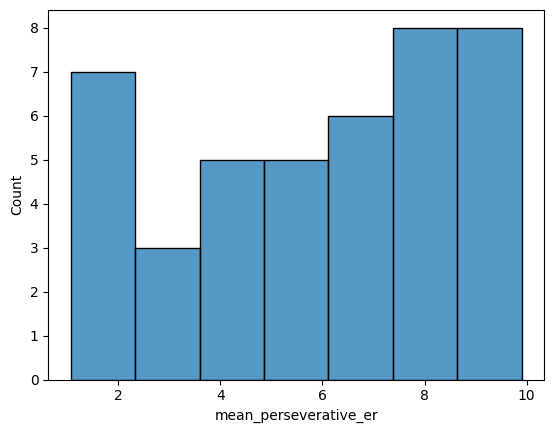

In [4]:
sns.histplot(data=task_summary, x="mean_perseverative_er") 
print('Perseverative error skew: '+str(skew(task_summary.mean_perseverative_er)))
#if skew isn't greater than 0.5 or less than -0.5 then nothing needs to be done
    #for an example of a skewed outcome (and what we would do) see regressive errors section

<b>Now run the initial hypothesis testing models</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

<b>H1a</b> Effect of feedback-type on perseverative error

In [5]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])

formula = 'mean_perseverative_er ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint feedback_fractals_randint  \
0   211.879878        215.495382        215.495382              NOT CONVERGE   

    randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  218.560348                  222.347099                           226.511335  


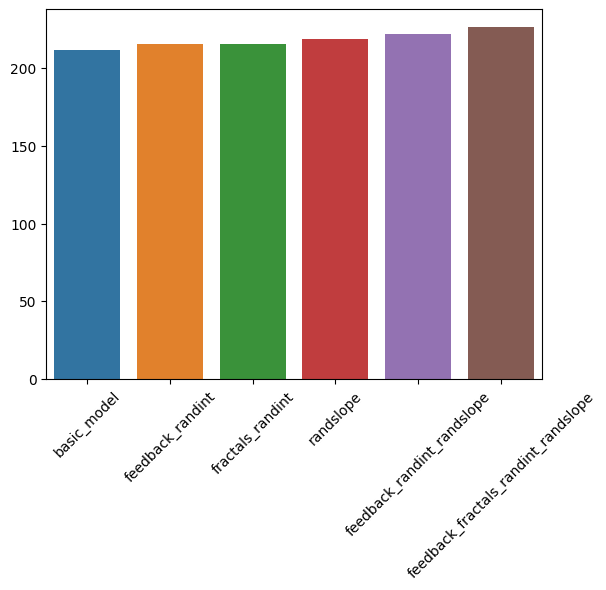

In [6]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, feedback randint is best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0    215.495382     217.612259     215.905258            217.579193   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0         219.329695                219.225222                  216.6024   

   sex_age_digit_span_covariate  
0                    219.952968  


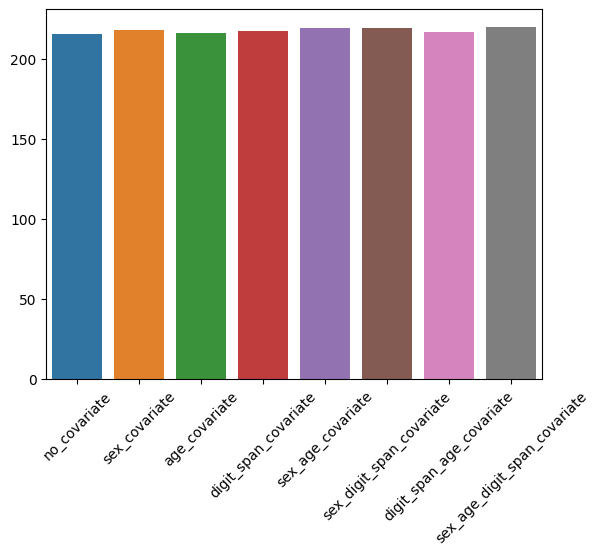

In [7]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, nocovariate is the best

In [8]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             ML                   
No. Groups:       14      Scale:              3.4689               
Min. group size:  3       Log-Likelihood:     -100.2724            
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 6.036    1.056  5.713 0.000  3.965  8.107
block_type               -0.024    0.418 -0.058 0.954 -0.843  0.794
feedback_details Var      3.469                                    
===================================================================

"""

Next, perform post-hoc tests to interpret any significant results

In [9]:
##do so using this function 
def post_hoc_stats(df, independent_var, dependent_var):
    #drop any participants with missing data on the dependent variable
    to_exclude=list(df[pd.isna(df[dependent_var])].participant_no)
    for participant in to_exclude:
        df=df[df['participant_no'] != participant]
    post_hoc =[]
    if independent_var=='block_type' or independent_var=='prolific_sex': ##categorical variables
        conditions=df[independent_var].unique()
        pairs=list(itertools.combinations(conditions, 2))

        for pair in pairs:
            condition1= df[df[independent_var]==pair[0]][dependent_var]
            condition2= df[df[independent_var]==pair[1]][dependent_var]

            if independent_var=='block_type': ##related t-test
                t_stat, p_value=ttest_rel(condition1, condition2)
                post_hoc.append((pair[0], pair[1], t_stat, p_value))
            elif independent_var=='prolific_sex': ##independent t-test
                t_stat, p_value=ttest_ind(condition1, condition2)
                post_hoc.append((pair[0], pair[1], t_stat, p_value))
        post_hoc=pd.DataFrame(post_hoc, columns=['condition1', 'condition2', 't_stat', 'p_value'])
        #Bonferroni corrections for multiple comparisons
        n_comparisons=len(post_hoc.index)
        post_hoc['corrected_p_value']=post_hoc['p_value']*n_comparisons
        post_hoc.loc[post_hoc['corrected_p_value']>1, 'corrected_p_value']=1
    else: ##correlations for continuous variables
        r, p= scipy.stats.pearsonr(df[dependent_var], df[independent_var])
        post_hoc.append((independent_var, r, p))
        post_hoc=pd.DataFrame(post_hoc, columns=['independent_var', 'r_stat', 'p_value'])
    return post_hoc

In [10]:
##e.g., if there was a significant effect of feedback type
post_hoc_stats(task_summary, 'block_type', 'mean_perseverative_er')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Disgust,Fear,-0.283215,0.781471,1.0
1,Disgust,Points,0.057239,0.955225,1.0
2,Fear,Points,0.331780,0.745343,1.0


<h4>Test the assumptions of the final model</h4> 
<p>The model we are basing our conclusions on
<p>(usually will be model 2 -->hypothesis test with only the significant covariates)

In [11]:
# checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9356392925357525
p-value 0.020168708869089554
LM Statistic 1.515072489123327
LM-Test p-value 0.46882006326802805
F-Statistic 0.7297509308857623
F-Test p-value 0.4884942704331563


<h4>Computing Bayes factor to see strength of the null</h4>
<li>This part is very much dependent on the outcome of the hypothesis test
<li>e.g., if there is no difference between fear and disgust in the hypothesis test --> will follow this up with a Bayesian t-test to see the strength of the null for this key comparison
<br>
<br>
<p>Will interpret this bayes factor using Figure 4 from:
<p>Van Doorn, Johnny & van den Bergh, Don & Boehm, Udo & Dablander, Fabian & Derks, Koen & Draws, Tim & Evans, Nathan & Gronau, Quentin & Hinne, Max & Kucharský, Šimon & Ly, Alexander & Marsman, Maarten & Matzke, Dora & Raj, Akash & Sarafoglou, Alexandra & Stefan, Angelika & Voelkel, Jan & Wagenmakers, Eric-Jan. (2019). The JASP Guidelines for Conducting and Reporting a Bayesian Analysis. Psychonomic Bulletin and Review. 10.3758/s13423-020-01798-5

In [12]:
##create a function to do this using the pinguouin package
        #NB for simplicity just doing pair-wise t-tests for key conditions
def bayes_factor(df, dependent_var, condition_1_name, condition_2_name):
    to_exclude=list(df[pd.isna(df[dependent_var])].participant_no)
    for participant in to_exclude:
        df=df[df['participant_no'] != participant]
    condition1=task_summary[task_summary.block_type==condition_1_name][dependent_var]
    condition2=task_summary[task_summary.block_type==condition_2_name][dependent_var]

    ttest=pg.ttest(condition1, condition2, paired=True)
    bf_null=1/float(ttest.BF10) ##convert this into a bayes factor for the strength of the null
    return bf_null

In [13]:
bayes_factor(task_summary, 'mean_perseverative_er', 'Fear', 'Disgust')

3.571428571428571

<b> MODEL 2: REGRESSIVE ERRORS </b>
<p> Same again but with regressive rather than perseverative errors</p>
<p> This time I have made the outcome variable skewed so show how this would be dealt with </p>

Firstly - check the outcome for skewness

Regressive error skew: 2.282893324119201


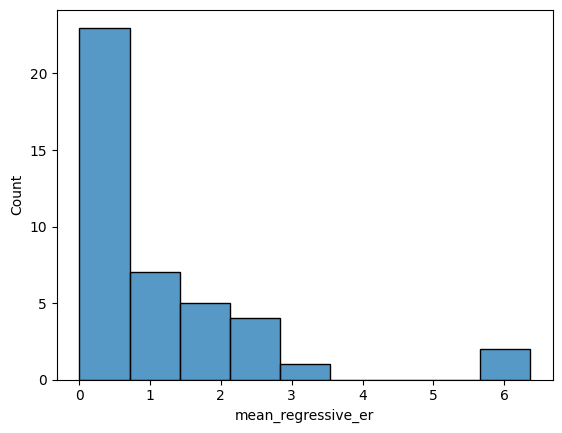

In [14]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution - so skew value >0.5
sns.histplot(data=task_summary, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary.mean_regressive_er,  nan_policy='omit')))

Given that the distribution was skewed, must perform a transformation

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

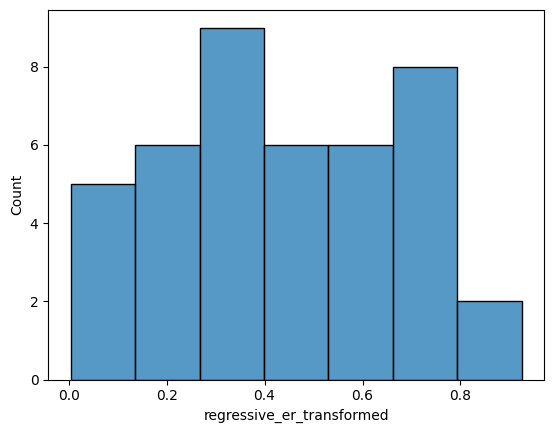

In [15]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
task_summary['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
sns.histplot(data=task_summary['regressive_er_transformed'])

<b>Now run the hypothesis testing model on the transformed variable</b>
<p><p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing (as with above):

In [16]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])

formula = 'regressive_er_transformed ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint feedback_fractals_randint  \
0    14.978109         14.978109         14.978109              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  23.823788                   26.004337                        NOT CONVERGE  


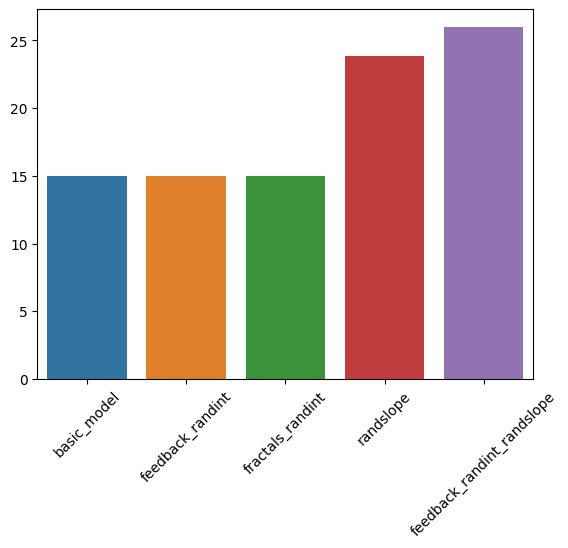

In [17]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)
        #also had to comment out because it does not converge and errors out

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})##added manually
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best (matched with feedback random intercepts)

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     14.978109      18.506601      18.713186             18.542258   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          22.167114                 22.105907                 22.262165   

   sex_age_digit_span_covariate  
0                     25.725426  


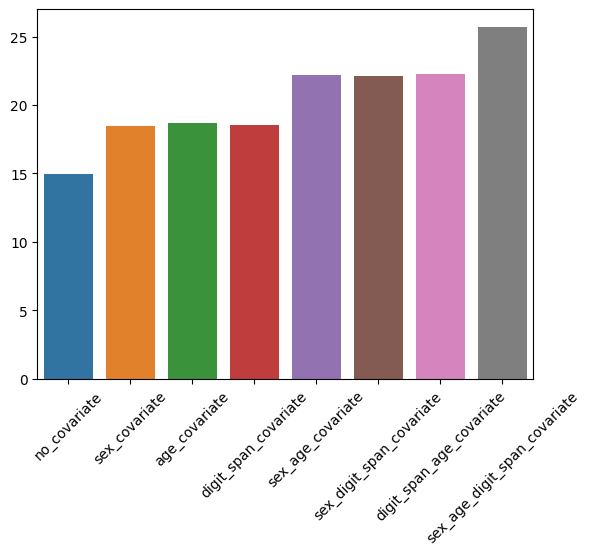

In [18]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, nocovariate is the best

In [19]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 42      Method:             ML                       
No. Groups:       14      Scale:              0.0586                   
Min. group size:  3       Log-Likelihood:     -0.0137                  
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
--------------------------------------------------------------------------
                 Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
--------------------------------------------------------------------------
Intercept         0.492       0.099     4.977    0.000     0.298     0.685
block_type       -0.027       0.046    -0.595    0.552    -0.117     0.062
Group Var         0.000       0.039                                       
=======================================================================

"""

Next, perform post-hoc tests to interpret any significant results

In [20]:
#Using the same function as above
##e.g., if there was a significant effect of feedback type
post_hoc_stats(task_summary, 'block_type', 'regressive_er_transformed')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Disgust,Fear,1.247777,0.234121,0.702364
1,Disgust,Points,0.672376,0.513118,1.000000
2,Fear,Points,-0.494363,0.629298,1.000000


Text(0.5, 1.0, 'Perseverative errors')

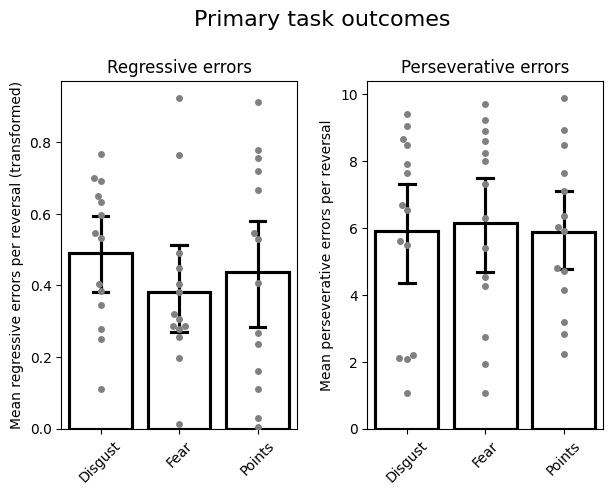

In [21]:
##NB plotting the data will also be used to help interpret results
#example plot:
fig, axes = plt.subplots(1,2, sharey=False)
title="Primary task outcomes"
plt.suptitle(title, fontsize=16)
#fig.set_size_inches(15, 5)
fig.tight_layout(pad=2)

sns.swarmplot(data=task_summary, x="block_type", y="regressive_er_transformed", ax=axes[0], color=".5", size=5, )
sns.barplot(data=task_summary, x="block_type", y="regressive_er_transformed", ax=axes[0], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
#axes[0].set_xlabel("Feedback type")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel("Mean regressive errors per reversal (transformed)") 
axes[0].set_title("Regressive errors") 

sns.swarmplot(data=task_summary, x="block_type", y="mean_perseverative_er", ax=axes[1], color=".5", size=5)
sns.barplot(data=task_summary, x="block_type", y="mean_perseverative_er", ax=axes[1], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
#axes[1].set_xlabel("Feedback type")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_ylabel("Mean perseverative errors per reversal") 
axes[1].set_title("Perseverative errors") 

Test the assumptions of this final model

In [22]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9709267545801271
p-value 0.35457550391198783
LM Statistic 4.454465246156623
LM-Test p-value 0.10782641395838236
F-Statistic 2.313512721806752
F-Test p-value 0.11233771237055806


Compute the Bayes factors for any null finding

In [23]:
bayes_factor(task_summary, 'regressive_er_transformed', 'Fear', 'Points')

3.3333333333333335

<h3><b>Adding video ratings</b></h3>
<p>Testing whether this result is modified by adding video ratings: </p>
<p>=models 3 and 4 in the analysis plan
<p><b>ONLY TO BE RUN IF RESULTS OF VIDEO RATINGS WARRANT IT</b>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

<b> MODEL 3: PERSEVERATIVE ERRORS W VIDEO RATINGS </b>

In [24]:
#e.g., if there was a difference in valence habituation and baseline arousal
# identified by a difference in valence habituation (valence_habdiff)
        #i.e., a time*stimulus type interaction in valence model (model A)
# and an effect of stimulus type in arousal model (model B)
#so add valence_habdiff and arousal_diff to the model as covariates

data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])

formula = 'mean_perseverative_er ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_andint  fractals_randint  feedback_fractals_randint  \
0    214.91001       216.305433        216.305433                 220.043103   

    randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  221.998318                  225.735988                        NOT CONVERGE  


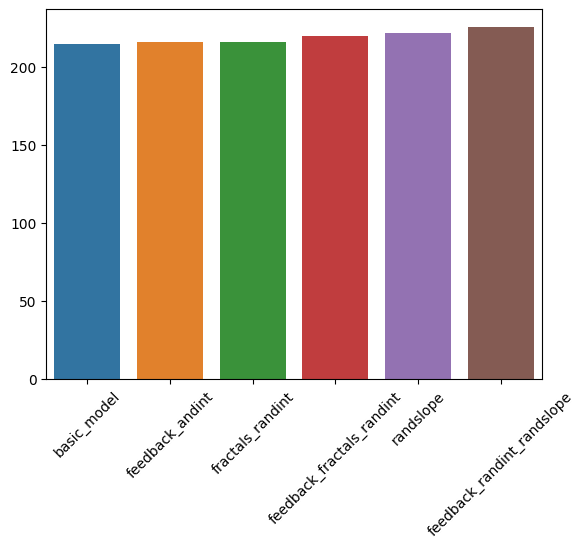

In [25]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     214.91001     213.520448     215.005044            217.705632   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          215.74443                215.902305                216.509428   

   sex_age_digit_span_covariate  
0                    217.242766  


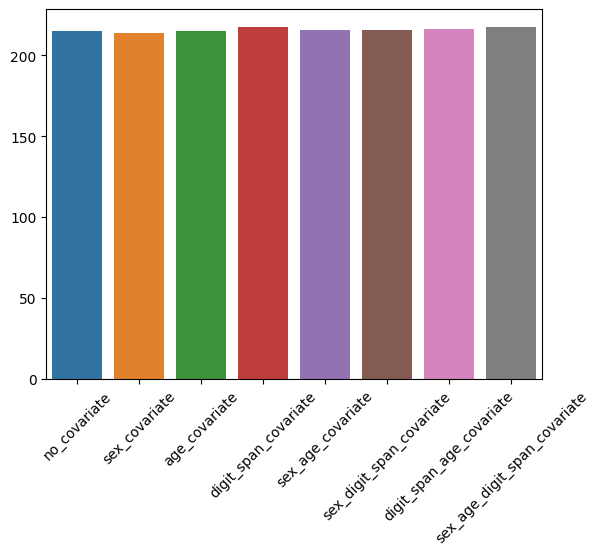

In [26]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, just the sex covariate is best

In [27]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
sex_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             ML                   
No. Groups:       14      Scale:              4.7932               
Min. group size:  3       Log-Likelihood:     -93.6784             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 4.792    1.023  4.683 0.000  2.786  6.798
prolific_sex[T.Male]      2.013    0.809  2.488 0.013  0.427  3.598
block_type               -0.024    0.414 -0.059 0.953 -0.835  0.787
arousal_diff              0.218    0.093  2.355 0.019  0.037  0.400
valence_habdiff          -0.157    0.071 -2.201 0.028 -0.296 -0.017
Group Var                 0.291    0.399                           
===================================================================

"""

In [28]:
#no covariate model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             ML                   
No. Groups:       14      Scale:              4.7932               
Min. group size:  3       Log-Likelihood:     -96.2420             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             5.976     0.939   6.368  0.000   4.137   7.816
block_type           -0.024     0.414  -0.059  0.953  -0.835   0.787
arousal_diff          0.194     0.111   1.749  0.080  -0.023   0.411
valence_habdiff      -0.092     0.080  -1.153  0.249  -0.248   0.064
Group Var             1.127     0.576                               
===================================================================

"""

In [29]:
#again checking assumptions

#chose model
results=sex_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9754702579933359
p-value 0.49428169616417195
LM Statistic 15.370834526718511
LM-Test p-value 0.28477770066374664
F-Statistic 1.2432388412620674
F-Test p-value 0.30266167101645497


<b> MODEL 4: REGRESSIVE ERRORS W VIDEO RATINGS </b>

Do the same for regressive errors

In [30]:
#e.g., same scenario as above
#note still using transformed outcome variable (as it is skewed)

formula = 'regressive_er_transformed ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_andint  fractals_randint feedback_fractals_randint  \
0    19.017317        19.016376         19.016376              NOT CONVERGE   

   randslope  feedback_randint_randslope feedback_fractals_randint_randslope  
0  27.674964                   30.272499                        NOT CONVERGE  


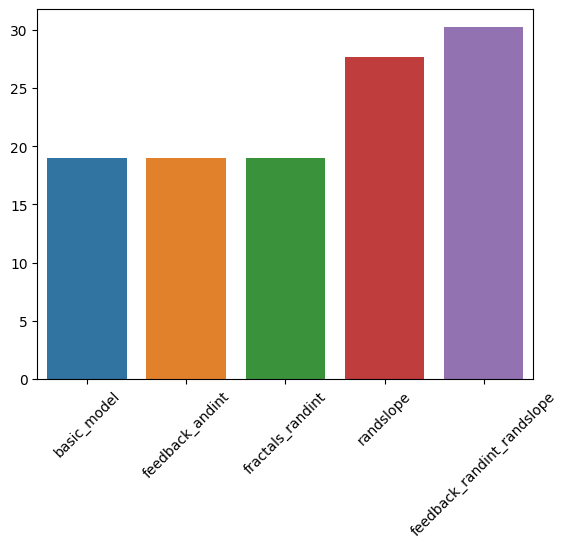

In [31]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     19.017317      22.153661      22.747122             22.669564   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          25.670308                 25.802783                 26.388186   

   sex_age_digit_span_covariate  
0                     29.255453  


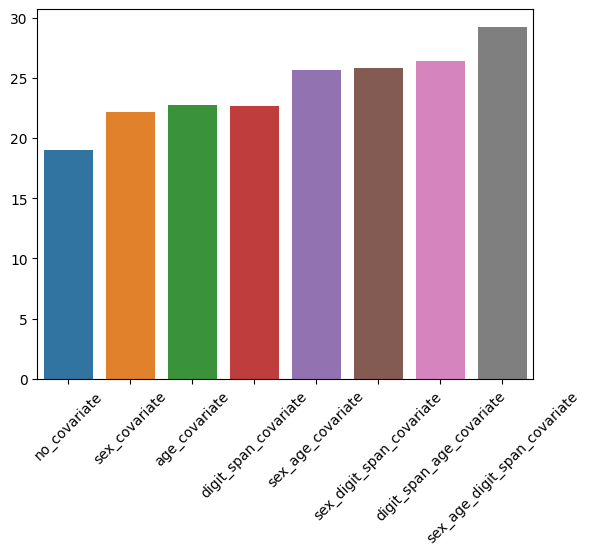

In [32]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, no covariate is best

In [33]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 42      Method:             ML                       
No. Groups:       14      Scale:              0.0540                   
Min. group size:  3       Log-Likelihood:     1.7044                   
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
-------------------------------------------------------------------------
                     Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
Intercept             0.492      0.095    5.188   0.000    0.306    0.678
block_type           -0.027      0.044   -0.620   0.535   -0.113    0.059
arousal_diff         -0.017      0.009   -1.888   0.059   -0.035    0.001
valence_habdiff      -0.001      0.006   -0.203   0.839   -0.014    0.011
Group Var             0.000      0.049                                   
=======================================================================

"""

In [34]:
#again checking assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.958454258319615
p-value 0.12998971778416363
LM Statistic 8.317241284707167
LM-Test p-value 0.5025190345430239
F-Statistic 0.8779688655166463
F-Test p-value 0.5544136490512794


<h3><b>Win-stay/lose-shift analyses</b></h3>
<p>Only to be run if there are differences in regressive or perseverative errors across the block types (significant effects of block type in models 1 or 2)</p>
<p>Models to run: </p>
<li> 5) 'win_stay ~ block_type + any covariates that were significant in models 1 and 2'
<li> 6) 'lose_shift ~ block_type + any covariates that were significant in models 1 and 2'

<b> MODEL 5: WIN-STAY </b>

Win-stay  skew: 0.27120031892898655


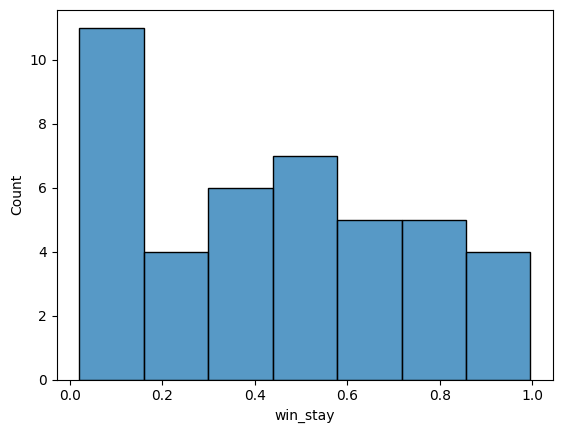

In [35]:
sns.histplot(data=task_summary, x="win_stay") 
print('Win-stay  skew: '+str(skew(task_summary.win_stay)))

In [36]:
##most basic model
formula = 'win_stay ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint  feedback_fractals_randint  \
0    28.290864         28.290512         28.290512                  32.028182   

   randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  36.034037                   38.478982                            42.235848  


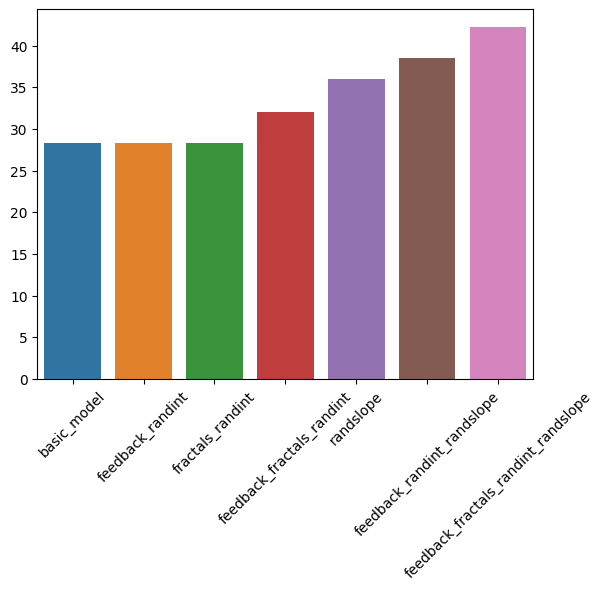

In [37]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, is is with feedback rand int (which fear/disgust vids used)

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     28.290512      31.583186      32.028057             31.538751   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          35.208323                 34.716162                 35.260716   

   sex_age_digit_span_covariate  
0                     38.408395  


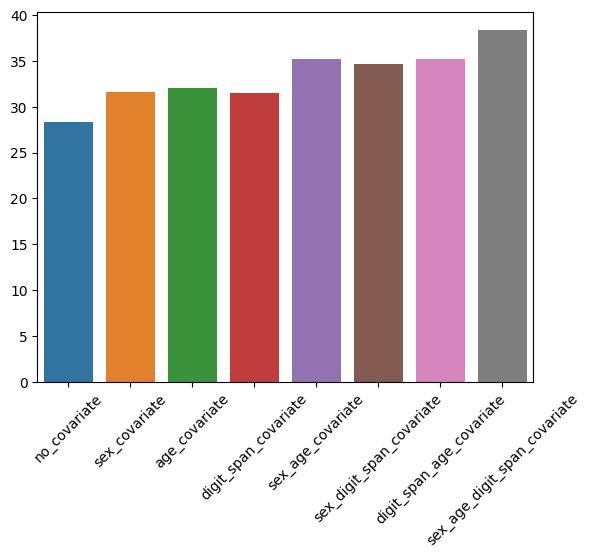

In [38]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, no covariate is best

In [39]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM   Dependent Variable:   win_stay
No. Observations:    42        Method:               ML      
No. Groups:          14        Scale:                0.0402  
Min. group size:     3         Log-Likelihood:       -6.6699 
Max. group size:     3         Converged:            Yes     
Mean group size:     3.0                                     
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.338    0.111 3.038 0.002  0.120  0.556
block_type           0.048    0.042 1.129 0.259 -0.035  0.130
feedback_details Var 0.040                                   
=============================================================

"""

Next, perform post-hoc tests to interpret any significant results

In [40]:
#e.g., a significant effect of sex
post_hoc_stats(task_summary, 'prolific_sex', 'win_stay')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Male,Female,-0.646639,0.521559,0.521559


Test the assumptions of this model

In [41]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9536577598972348
p-value 0.08738362624878865
LM Statistic 0.9304924067918905
LM-Test p-value 0.6279804752296226
F-Statistic 0.4418022760867611
F-Test p-value 0.6460542781305333


Also calculate Bayes factor for strenght of null

In [42]:
bayes_factor(task_summary, 'win_stay', 'Fear', 'Disgust')

3.4722222222222223

<b> MODEL 6: LOSE-SHIFT </b>

lose-shift  skew: 0.27120031892898655


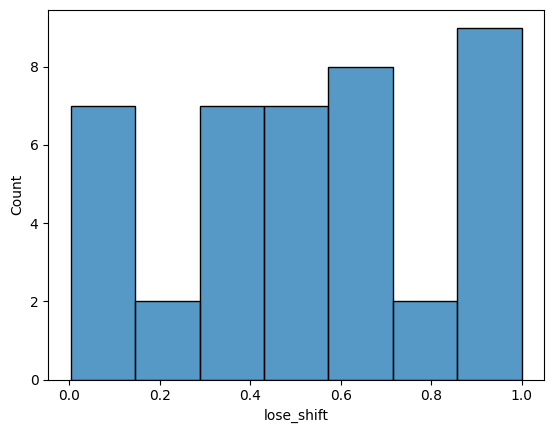

In [43]:
#check for skewness
sns.histplot(data=task_summary, x="lose_shift") 
print('lose-shift  skew: '+str(skew(task_summary.win_stay, nan_policy='omit')))

Now run the hypothesis testing model (with any covariates that were significant in models 1 and 2)

In [44]:
formula = 'lose_shift ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint  feedback_fractals_randint  \
0    31.792901         31.792146         31.792146                  35.529815   

   randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  38.998873                   41.563996                             44.97448  


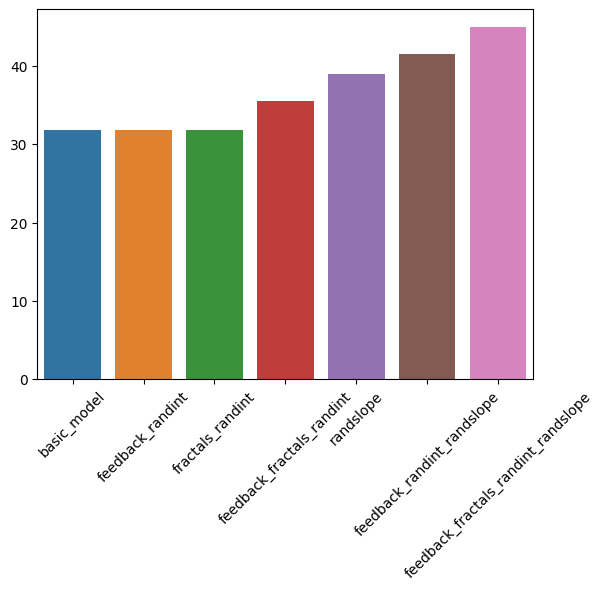

In [45]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, it is feedback random intercepts

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     31.792146      35.486933      35.365098             34.404824   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          38.920594                 38.132575                 37.747763   

   sex_age_digit_span_covariate  
0                     41.320216  


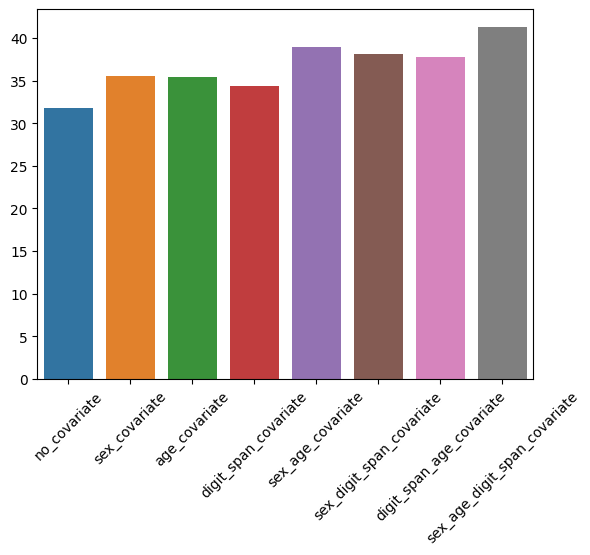

In [46]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, no covariate is best

In [47]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  lose_shift
No. Observations:    42       Method:              ML        
No. Groups:          14       Scale:               0.0437    
Min. group size:     3        Log-Likelihood:      -8.4207   
Max. group size:     3        Converged:           Yes       
Mean group size:     3.0                                     
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.494    0.061 8.078 0.000  0.374  0.614
block_type           0.017    0.044 0.372 0.710 -0.071  0.104
feedback_details Var 0.044                                   
=============================================================

"""

Test the assumptions of this model

In [48]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9537637965359603
p-value 0.08815422686588852
LM Statistic 1.4136302015465485
LM-Test p-value 0.4932125308514741
F-Statistic 0.6791883350751939
F-Test p-value 0.5129238516327049


Calculate Bayes factor (if there is a null)

In [49]:
bayes_factor(task_summary, 'lose_shift', 'Fear', 'Points')

3.6101083032490973

<b>Finally (!) may also test the impact of adding video ratings to these analyses </b>
<p>This is very similar to models 3 and 4, i.e., is contingent on video rating analysis

In [50]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])

formula = 'win_stay ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint  feedback_fractals_randint  \
0    31.314463         30.917555         30.917555                  34.655224   

   randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  40.083739                   41.255053                            45.115892  


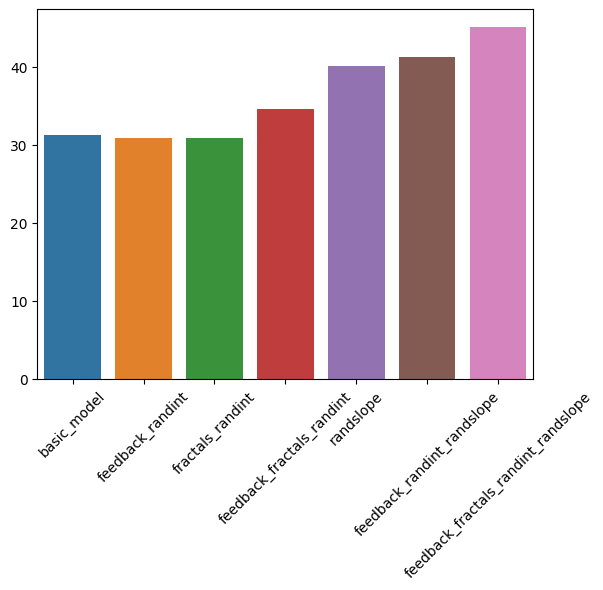

In [51]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, video-type (feedback_randint) is best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     30.917555      32.791861      34.654054             34.110946   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          36.145774                 35.968424                 37.824119   

   sex_age_digit_span_covariate  
0                      39.46124  


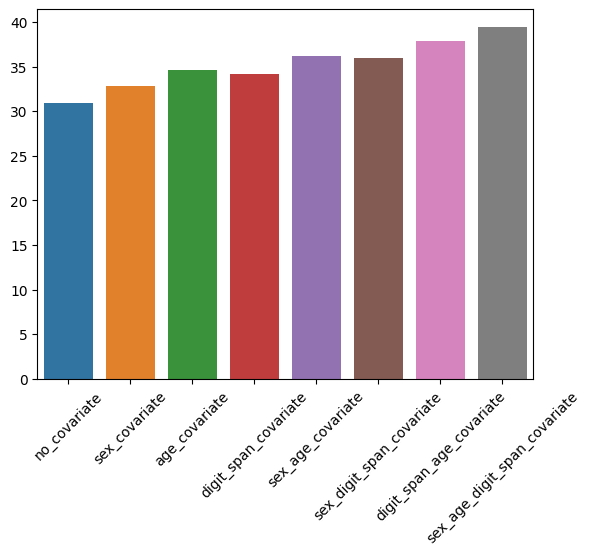

In [52]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, the most basic is best (no covariates)

In [53]:
#so hypothesis test on the no covariate model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    win_stay
No. Observations:    42         Method:                ML      
No. Groups:          14         Scale:                 0.0358  
Min. group size:     3          Log-Likelihood:        -4.2458 
Max. group size:     3          Converged:             Yes     
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.341    0.103  3.327 0.001  0.140  0.543
block_type            0.048    0.041  1.159 0.247 -0.033  0.128
arousal_diff         -0.022    0.009 -2.444 0.015 -0.039 -0.004
valence_habdiff       0.004    0.007  0.519 0.604 -0.010  0.017
feedback_details Var  0.036                                    
===============================================================

"""

In [54]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.934973186343272
p-value 0.019132315359102755
LM Statistic 4.717371418971361
LM-Test p-value 0.8582170938745008
F-Statistic 0.44988448493885275
F-Test p-value 0.8967282918938925


Same for lose-shift

In [55]:
formula = 'lose_shift ~ block_type + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

   basic_model  feedback_randint  fractals_randint feedback_fractals_randint  \
0    37.906218         37.904991         37.904991              NOT CONVERGE   

   randslope  feedback_randint_randslope  feedback_fractals_randint_randslope  
0  42.473262                    48.19433                             52.47345  


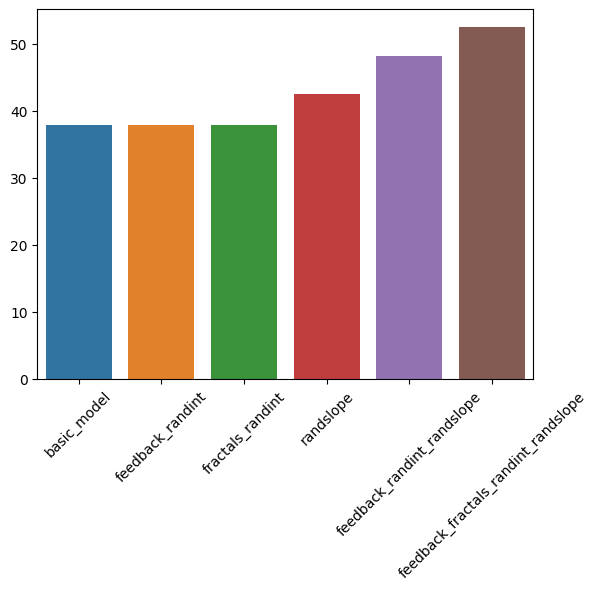

In [56]:
#test which random effects to include
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': [feedback_randint.bic], 
                    'fractals_randint': [fractals_randint.bic],
                    'feedback_fractals_randint': ['NOT CONVERGE'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, feedback rand int is best

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0     37.904991       41.56899      41.360875             40.928275   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0          45.096197                 44.592782                 44.199495   

   sex_age_digit_span_covariate  
0                      47.93628  


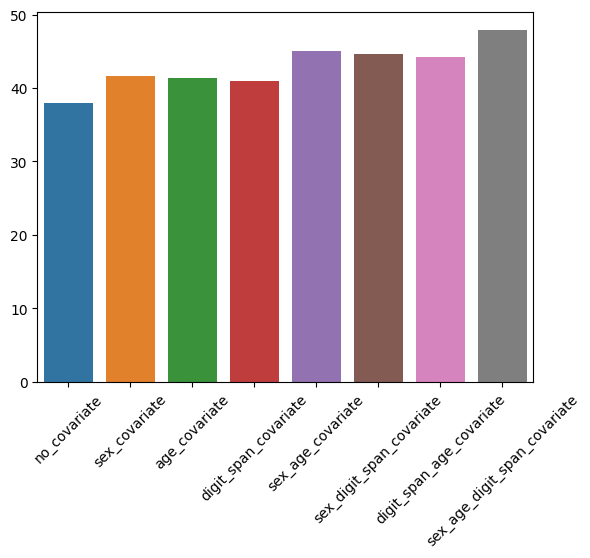

In [57]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, the most basic is best (no covariates)

In [58]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   lose_shift
No. Observations:    42        Method:               ML        
No. Groups:          14        Scale:                0.0423    
Min. group size:     3         Log-Likelihood:       -7.7395   
Max. group size:     3         Converged:            Yes       
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.498    0.020 24.480 0.000  0.458  0.538
block_type            0.017    0.027  0.615 0.538 -0.036  0.069
arousal_diff         -0.006    0.011 -0.499 0.618 -0.028  0.016
valence_habdiff       0.008    0.008  0.974 0.330 -0.008  0.024
feedback_details Var  0.042                                    
===============================================================

"""

In [59]:
#final check of model assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9719406471442733
p-value 0.38282213360614153
LM Statistic 20.521878370007776
LM-Test p-value 0.014951140494570612
F-Statistic 3.397256049943644
F-Test p-value 0.004950973448745565
